# **TASK 3**
##Implement two hidden layers neural network classifier from scratch in JAX

- Two hidden layers here means (input - hidden1 - hidden2 - output)
-  Use MNIST dataset with 80:20 train:test split
-  Use gradient descent from scratch to optimize your network
- Plot loss v/s iterations curve with matplotlib.





# **MLP training on MNIST**

### **IMPORTS AND DEPENDENCIES**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as onp
import seaborn as sns
import matplotlib.pyplot as plt

#We simply import the JAX version of NumPy as well as the good old vanilla version
#Most of the standard NumPy functons are supported by JAX and can be called in the standard fashion.

import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)


# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms

import time

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


- **jit** (just-in-time compilation) lies at the core of speeding up your code. 
- In practice we simply wrap `(jit())` or decorate `(@jit)` the function of interest.

In [2]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

In [3]:
batch_dim = 32
feature_dim = 100
hidden_dim = 512

# Generate a batch of vectors to process
X = random.normal(key, (batch_dim, feature_dim))

# Generate Gaussian weights and biases
params = [random.normal(key, (hidden_dim, feature_dim)),
          random.normal(key, (hidden_dim, ))]

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

out = np.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])
out = batch_version_relu_layer(params, X)
out = vmap_relu_layer(params, X)

In [4]:
def plot_mnist_examples(train_loader):
    # Plot some MNIST example samples
    for batch_idx, (data, target) in enumerate(train_loader):
        images = np.array(data[:4, ...]).reshape(4, 28, 28)
        target = np.array(target[:4, ...])
        break

    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i,...], cmap="Greys")
        ax.set_title("Label: {}".format(target[i]), fontsize=30)
        ax.set_axis_off()
    fig.tight_layout()

# **Training a MNIST Multilayer Perceptron in JAX**

We define a simple PyTorch MNIST dataloader and afterwards set everything up to train. 

JAX is a purely functional programming framework. Hence, we cant wrap things in class instances or modules used for example from the PyTorch `nn.Module `semantics. 

We, therefore, will need the following functions to train a Multilayer Perceptron:

- A function that **initializes the neural networks weights** and returns a list of layer-specific parameters.
- A function that performs a **forward pass** through the network (e.g. by loop over the layers).
- A function that computes the **cross-entropy loss** of the predictions.
- A function that **evaluates the accuracy** of the network (simply for logging).
- A function that **updates the parameters** using some form gradient descent.

### **Set the PyTorch Data Loader for the training & test set**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



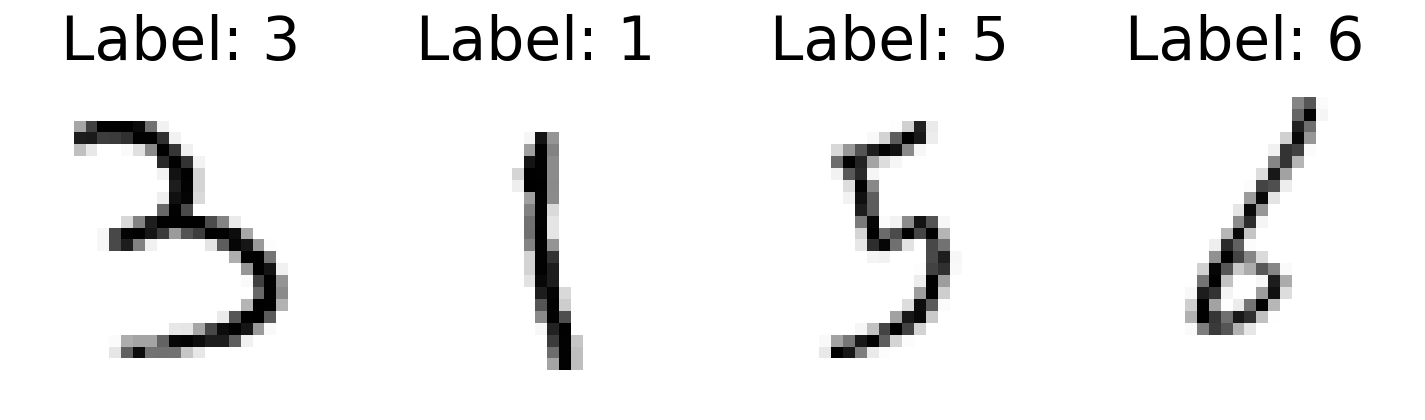

In [5]:

batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)


plot_mnist_examples(train_loader)

### **Function to initialize weights**
- Will pass a list of hidden layer sizes and the previously generated PRNG key
- We need to split the key iteratively to generate the individual weights of our network


Our MLP that takes the flat MNIST image as an input `(28 x 28 = 784)`  and has two hidden layers with 512 units `(e.g. 784-512-512-10)`

In [6]:
# initialize_mlp : initializes the weights in our MLP
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

### **Defininig the forward Pass function**

- We define the forward pass through the network by iteratively looping over the layers and returning the log of the softmax output/predictions
- Afterwards, we `vmap` the single case to create a batched version
- `vmap` lets you simply write your computations for a single sample case and afterwards wrap it to make it batch compatible

In [7]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

## **Cross Entropy Loss**
-  we define which function we would like to optimize - This is going to be the **multi-class cross-entropy loss** between the one-hot encoded class labels ($y_i \in \mathbb{R}^{10}$) and the softmax output of the network ($p^\theta(x_i) \in \mathbb{R}^{10}$):

$$ - \sum_{c=1}^{10} y_{ic} \log p^\theta_{c}(x_i) $$




In [8]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)

def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

## **Updating Parameters**
- `update` function computes the gradient of the loss with respect to the parameters for a batch
- We use the predefined optimizers and choose Adam to be our optimizer for the initialized parameters

In [9]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10

## **Training Loop**
-  learning loop for the 2-layer MLP

In [10]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

    return train_loss, log_acc_train, log_acc_test


train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")



Epoch 1 | T: 20.44 | Train A: 0.974 | Test A: 0.968
Epoch 2 | T: 19.62 | Train A: 0.984 | Test A: 0.973
Epoch 3 | T: 19.53 | Train A: 0.990 | Test A: 0.978
Epoch 4 | T: 19.35 | Train A: 0.993 | Test A: 0.979
Epoch 5 | T: 19.47 | Train A: 0.993 | Test A: 0.979
Epoch 6 | T: 19.41 | Train A: 0.997 | Test A: 0.980
Epoch 7 | T: 19.55 | Train A: 0.998 | Test A: 0.981
Epoch 8 | T: 19.23 | Train A: 0.995 | Test A: 0.978
Epoch 9 | T: 19.17 | Train A: 0.997 | Test A: 0.980
Epoch 10 | T: 19.06 | Train A: 0.997 | Test A: 0.979


## **Plotting Loss and Accuracy**

In [11]:
def plot_mnist_performance(train_loss, train_acc, test_acc,
                           sup_title="Loss Curve"):
    """ Visualize the learning performance of a classifier on MNIST """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_loss)
    axs[0].set_xlabel("# Batch Updates")
    axs[0].set_ylabel("Batch Loss")
    axs[0].set_title("Training Loss")

    axs[1].plot(train_acc, label="Training")
    axs[1].plot(test_acc, label="Test")
    axs[1].set_xlabel("# Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Prediction Accuracy")
    axs[1].legend()

    # Give data more room to bloom!
    for i in range(2):
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)

    fig.suptitle(sup_title, fontsize=25)
    fig.tight_layout(rect=[0, 0.03, 1, 0.925])

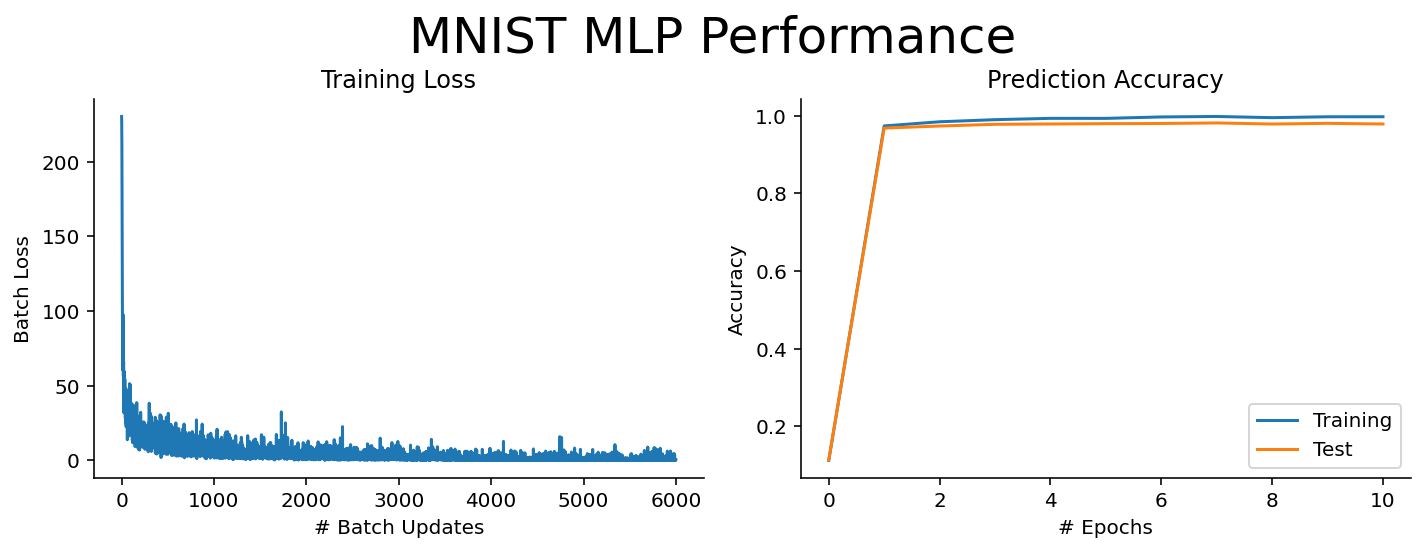

In [12]:
# Plot the loss curve over time
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST MLP Performance")